In [1]:
import os ; import sys
sys.path.append(os.getcwd()+"/../../src")
sys.path.append(os.environ["PYQULAROOT"])

from qtcipy import interpolate

# Selfconsistent calculations with KPM QTCI


## Algorithm
The next cell defines the functions required for the algorithm

In [2]:
# you do not have to modify this cell

import numpy as np

def get_density_i(m,fermi=0.,i=0,delta=1e-1):
    """Return electronic density at site i"""
    ne = 1000 # number of energies
    scale = 10.0 # scale of KPM method
#    delta = 0.1 # effective smearing
    from pyqula import kpm
    (es,ds) = kpm.ldos(m,i=i,ne=ne,npol=5*int(scale/delta)) # compute the LDOS with KPM
#    print(ds).real
    ds = ds.real # just the real part
    return np.sum(ds[es<fermi])/np.sum(ds) # return filling of the site


def get_den_ed(h,fermi=0.,**kwargs):
    """Return the total electronic density using exact diagonalization"""
    from scipy.linalg import eigh
    if h.shape[0]>1000: raise # sanity check
    (es,ws) = eigh(h.todense()) # diagonalize
    ws = ws.T # wavefucntions as rows
    out = 0. # initialize
    for i in range(len(es)):
        if es[i]<fermi: out += np.abs(ws[i])**2 # add contribution
    return out


def get_den_kpm(h,use_qtci=True,info_qtci=False,**kwargs):
    """Return the electronic density of the system uisng KPM and QTCI"""
    def f(i): # function to interpolate
        return get_density_i(h,i=int(i),**kwargs)
    if use_qtci: # use quantics tensor corss interpolation
        xlim = [0,h.shape[0]] # limits of the interpolation
        nb = 5
        nb = np.log(h.shape[0])/np.log(2)
        if np.abs(int(nb)-nb)>1e-5:
            pritn("Number of points must be a power of 2")
            raise
        nb = int(nb) # number of points
        IP = interpolate.Interpolator(f,tol=1e-3,nb=nb,xlim=xlim,dim=1)
        rse,zse = IP.get_evaluated()
        if info_qtci:
             print(len(rse)/h.shape[0],"ratio of evaluations") 
        return np.array([IP(float(i)) for i in range(0,h.shape[0])])
    else: # brute force
        return np.array([f(i) for i in range(0,h.shape[0])])


def get_den(h,use_kpm=False,**kwargs):
    if use_kpm: return get_den_kpm(h,**kwargs) # compute using the KPM
    else: return get_den_ed(h,**kwargs) # compute using the KPM


def SCF_Hubbard(h0,U=0.,dup=None,ddn=None,maxerror=1e-3,
                mix=0.3,info=False,**kwargs):
    """
    Perform a selfconsistent Hubbard calculation
       - h0 is the single particle Hamiltonian
       - U is the Hubbard interaction
       - dup is the initial guess for the up density
       - ddn is the initial guess for the dn density
       - maxerror is the maximum error of the selfconsistent loop
       - mix mixes the mean field, for stability
       """
    ddn_old = ddn.copy() # make a copy
    dup_old = dup.copy() # make a copy
    from scipy.sparse import diags
    while True: # infinite loop
        hup = h0 + U*diags(ddn_old-0.5,shape=h0.shape) # up Hamiltonian
        hdn = h0 + U*diags(dup_old-0.5,shape=h0.shape) # down Hamiltonian
        ddn = get_den(hdn,**kwargs) # generate down density
        dup = get_den(hup,**kwargs) # generate up density
        error = np.mean(np.abs(ddn-ddn_old) + np.abs(dup-dup_old)) # error
        if info: print("Error",error)
        if error<maxerror: break # stop loop
        dup_old = mix*dup_old + (1.-mix)*dup # update
        ddn_old = mix*ddn_old + (1.-mix)*ddn # update
    return hup,hdn,dup,ddn # return Hamiltonian and densities




# One-dimensional chain
Let us now test the algorithm with a one-dimensional chain

In [3]:
# define a first neighbor tight binding model
L = 4 # exponential length
n = 2**L # number of sites
rows,cols = np.array(range(0,n-1)),np.array(range(1,n)) # indexes
data = np.array([1. for i in range(n-1)],dtype=np.complex_) # hopping 1 for all
from scipy.sparse import csc_matrix
h0 = csc_matrix((data,(rows,cols)),shape=(n,n),dtype=np.complex_) # create single particle hopping
h0 = h0 + h0.T # add the transpose

get_density_i(h0)

0.5000000000000002

### Mean-field calculation with ED
As a reference, lets first perform the ED calculation

Error 1.375
Error 0.11515729335678455
Error 0.03980458389300578
Error 0.029750845280396076
Error 0.02470330715439187
Error 0.019954173576746788
Error 0.015817638460013973
Error 0.012367975952090255
Error 0.009572865718221156
Error 0.0073535703014133945
Error 0.005617040249482005
Error 0.0042726625781456355
Error 0.0032399766062164784
Error 0.00245125718132096
Error 0.001851407018638937
Error 0.0013966142082555144
Error 0.0010525872383127
Error 0.0007927844491648524


Text(0.5, 0, 'Site index')

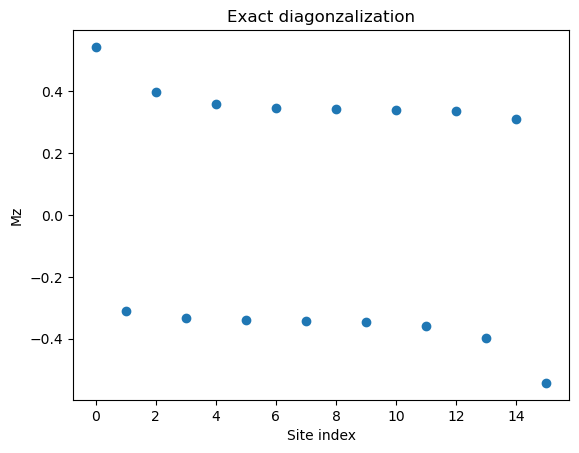

In [4]:
# perform a mean-field calculation using ED

dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize

hup_ed,hdn_ed,dup_ed,ddn_ed = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=False,info=True,U=2.)

import matplotlib.pyplot as plt

plt.title("Exact diagonzalization")
plt.scatter(range(len(dup_ed)),dup_ed-ddn_ed)
plt.ylabel("Mz") ; plt.xlabel("Site index")

# perform a mean-field calculation using KPM (just as a reference)

dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize

hup_kpm,hdn_kpm,dup_kpm,ddn_kpm = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=True,use_qtci=False,
                              info=True,U=2.,delta=.2)

import matplotlib.pyplot as plt


plt.scatter(range(len(dup_kpm)),dup_kpm-ddn_kpm)

Error 1.3307262631951362
Error 0.12590969459914825
Error 0.03602087130239884
Error 0.02726899230850562
Error 0.022494720447188112
Error 0.01804263315397566
Error 0.014198606545417046
Error 0.011037784156343424
Error 0.00850375970742409
Error 0.006508418230469338
Error 0.004957035581259208
Error 0.0037619275814388467
Error 0.002847468971270124
Error 0.0021512007420579383
Error 0.0016229689238561468
Error 0.0012232668363275634
Error 0.0009213902796941821


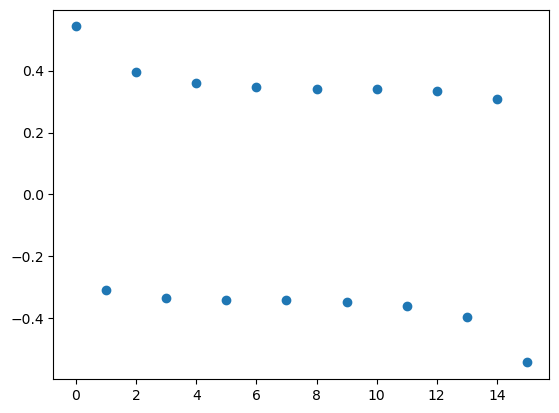

In [5]:
# perform a mean-field calculation using KPM and QTCI

dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize

hup,hdn,dup,ddn = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=True,use_qtci=True,
                              info=True,U=2.,delta=.2)

import matplotlib.pyplot as plt


plt.scatter(range(len(dup)),dup-ddn)

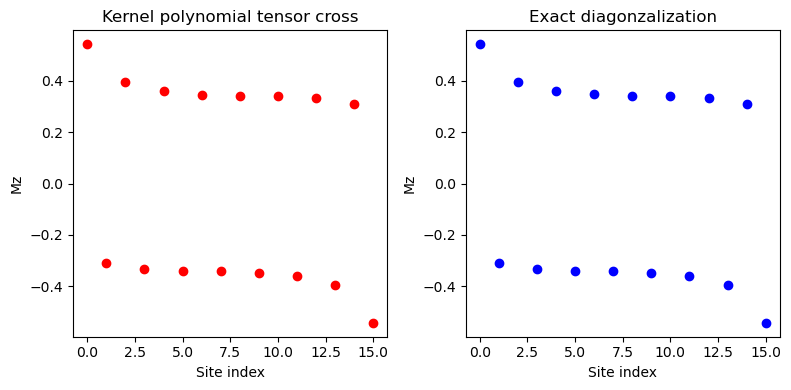

In [6]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Kernel polynomial tensor cross")
plt.scatter(range(len(dup)),dup-ddn,label="KPM+QTCI",c="red")
plt.ylabel("Mz") ; plt.xlabel("Site index")

plt.subplot(1,2,2)
plt.title("Exact diagonzalization")
plt.scatter(range(len(dup_ed)),dup_ed-ddn_ed,c="blue")
plt.ylabel("Mz") ; plt.xlabel("Site index")

plt.tight_layout()

16384 Sites
0.0469970703125 ratio of evaluations
0.056884765625 ratio of evaluations
Error 1.303150180429435
0.04632568359375 ratio of evaluations
0.04925537109375 ratio of evaluations
Error 0.08802064404352865
0.0467529296875 ratio of evaluations
0.05010986328125 ratio of evaluations
Error 0.026206874678966763
0.0416259765625 ratio of evaluations
0.044921875 ratio of evaluations
Error 0.018697462804157024
0.04705810546875 ratio of evaluations
0.0408935546875 ratio of evaluations
Error 0.015259506190581914
0.0533447265625 ratio of evaluations
0.06134033203125 ratio of evaluations
Error 0.012303248800582348
0.0546875 ratio of evaluations
0.05804443359375 ratio of evaluations
Error 0.009821754613556586
0.05023193359375 ratio of evaluations
0.05828857421875 ratio of evaluations
Error 0.007786474123472981
0.04595947265625 ratio of evaluations
0.068603515625 ratio of evaluations
Error 0.006137655598770748
0.04730224609375 ratio of evaluations
0.06182861328125 ratio of evaluations
Error 0.00

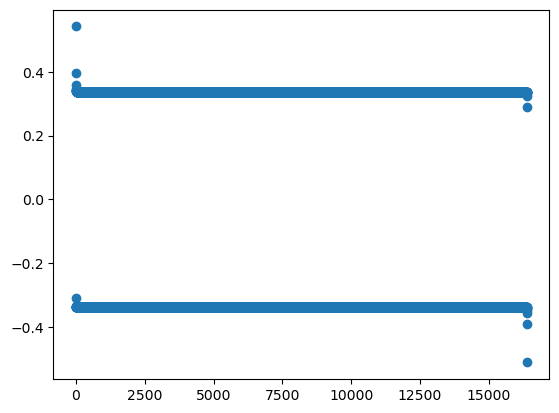

In [7]:
# define a first neighbor tight binding model
L = 14 # exponential length
n = 2**L # number of sites
rows,cols = np.array(range(0,n-1)),np.array(range(1,n)) # indexes
data = np.array([1. for i in range(n-1)]) # hopping 1 for all
from scipy.sparse import csc_matrix
h0 = csc_matrix((data,(rows,cols)),shape=(n,n)) # create single particle hopping
h0 = h0 + h0.T # add the transpose

print(h0.shape[0],"Sites")

# perform a mean-field calculation using KPM and QTCI


dup0 = 0.2*np.array([(-1)**i for i in range(h0.shape[0])])
ddn0 = -dup0 # initialize

use_kpm,use_qtci = True,True
#use_kpm,use_qtci = False,False

hup,hdn,dup,ddn = SCF_Hubbard(h0,ddn=ddn0,dup=dup0,use_kpm=use_kpm,use_qtci=use_qtci,
                              info=True,info_qtci=True,U=2.,delta=0.2)

import matplotlib.pyplot as plt


plt.scatter(range(len(dup)),dup-ddn)

Text(0.5, 0, 'Site index')

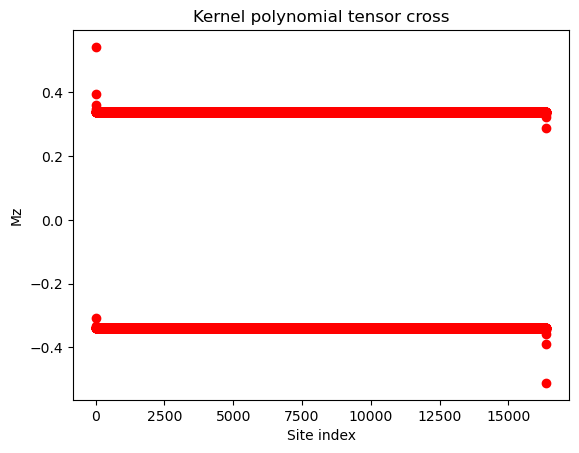

In [8]:
plt.title("Kernel polynomial tensor cross")
plt.scatter(range(len(dup)),dup-ddn,label="KPM+QTCI",c="red")
plt.ylabel("Mz") ; plt.xlabel("Site index")